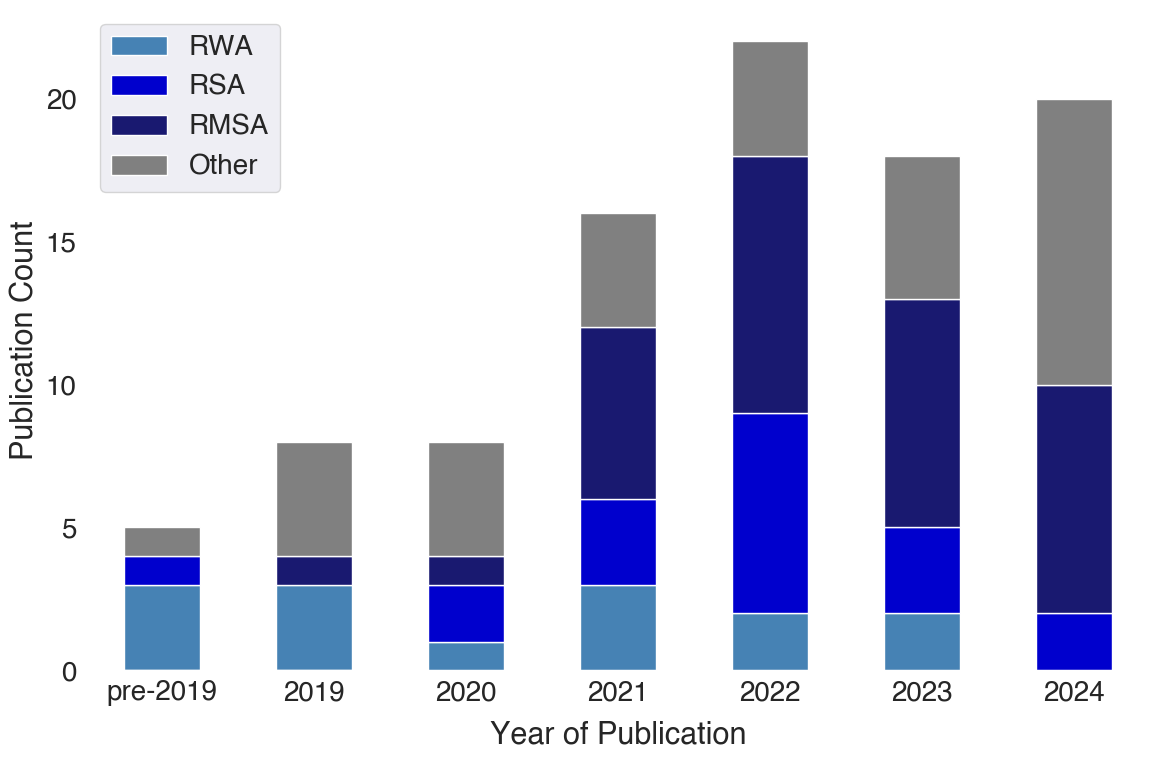

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# Read the CSV file
df = pd.read_csv('/Users/michaeldoherty/git/XLRON/data/JOCN2024//RL RSA.csv')

# Convert 'Publication Year' to numeric, dropping any non-numeric values
df['Publication Year'] = pd.to_numeric(df['Publication Year'], errors='coerce')

# Drop rows with NaN values in 'Publication Year'
df = df.dropna(subset=['Publication Year'])

# Group years 2017 and earlier into 'pre-2018'
df['Publication Year'] = df['Publication Year'].apply(lambda x: 'pre-2019' if x <= 2018 else x)

# Define categories in order of priority
#categories = ['Grooming', 'Defragmentation', 'Survivability', 'Toolkit', 'Multicast', 'Multicore', 'Multiband', 'Routing', 'RWA', 'RSA', 'RMSA']
categories = ['RWA', 'RSA', 'RMSA']#, 'Routing']

# Create a function to categorize papers
def categorize_paper(tags):
    try:
        tags_lower = tags.lower()
    except:
        print(tags)
    for category in categories:
        if category.lower() in tags_lower:
            return category
    return 'Other'

# Apply the categorization
df['Manual Tags'] = df['Manual Tags'].fillna('Other')
df['Category'] = df['Manual Tags'].apply(categorize_paper)

# Group by year and category, and count the papers
grouped = df.groupby(['Publication Year', 'Category']).size().unstack(fill_value=0)

# Sort the columns in the desired order
column_order = ['RWA', 'RSA', 'RMSA', 'Other']
grouped = grouped.reindex(columns=column_order, fill_value=0)

# Sort the index (years) to ensure 'pre-2018' comes first
year_order = ['pre-2019'] + sorted([year for year in grouped.index if year != 'pre-2019'])
grouped = grouped.reindex(year_order)

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_facecolor('white')

# Set up Helvetica font
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica', 'Arial', 'DejaVu Sans', 'Bitstream Vera Sans', 'sans-serif']
plt.rcParams.update({'font.size': 20})

# Define color scheme
color_scheme = {
    'Grooming': '#FFA500',  # Orange
    'Defragmentation': '#FF4500',  # OrangeRed
    'Survivability': '#32CD32',  # LimeGreen
    'Toolkit': '#FFD700',  # Gold
    'Multicast': '#8A2BE2',  # BlueViolet
    'Multicore': '#FF69B4',  # HotPink
    'Multiband': '#20B2AA',  # LightSeaGreen
    'Routing': '#87CEFA',  # LightSkyBlue
    'RWA': '#4682B4',  # SteelBlue
    'RMSA': '#191970',  # MediumBlue
    'RSA': '#0000CD',  # MidnightBlue
    'Other': '#808080'  # Grey
}
grouped.plot(kind='bar', stacked=True, ax=ax, color=[color_scheme.get(x, '#000000') for x in grouped.columns])

# Make x-axis labels horizontal
plt.xticks(rotation=0, ha='center')

# Adjust bottom margin if needed
#plt.subplots_adjust(bottom=0.3)
# Increase x-tick font size
plt.xticks(fontsize=20)
# Increase y-tick font size
plt.yticks(fontsize=20)

# Customize the chart
#plt.title('Publication Count by Category and Year', fontsize=16)
plt.xlabel('Year of Publication', fontsize=22, labelpad=10)
plt.ylabel('Publication Count', fontsize=22)
plt.legend(loc='upper left', fontsize=20)
#plt.background_color = 'white'
plt.tight_layout()

plt.savefig('RL_RSA_litreview_barchart.png')

# Show the plot
plt.show()

In [6]:
import pandas as pd
import bibtexparser
from bibtexparser.bparser import BibTexParser
from bibtexparser.customization import convert_to_unicode
from fuzzywuzzy import fuzz

# Read the CSV file
df = pd.read_csv('/Users/michaeldoherty/git/XLRON/data/JOCN2024/RL RSA.csv')

# Read the BibTeX file
with open('/Users/michaeldoherty/git/XLRON/data/JOCN2024/RL RSA.bib', 'r', encoding='utf-8') as bibtex_file:
    parser = BibTexParser()
    parser.customization = convert_to_unicode
    bib_database = bibtexparser.load(bibtex_file, parser=parser)

# Create a list of BibTeX entries
bib_entries = bib_database.entries

# Function to find matching BibTeX entry and extract the citation tag
def find_matching_entry_and_tag(row):
    best_match = None
    best_ratio = 0
    for entry in bib_entries:
        ratio = fuzz.token_sort_ratio(row['Title'].lower(), entry.get('title', '').lower())
        if ratio > best_ratio:
            best_ratio = ratio
            best_match = entry
    
    if best_match and best_ratio > 80:  # You can adjust this threshold
        return best_match.get('ID', '')
    return ''

# Apply the function to each row and create the citation tag column
df['Citation_Tag'] = df.apply(find_matching_entry_and_tag, axis=1)

# Display the first few rows of the updated DataFrame
print(df[['Title', 'Citation_Tag']].head())

# Print some statistics
total_entries = len(df)
matched_entries = df['Citation_Tag'].notna().sum()
print(f"\nTotal entries: {total_entries}")
print(f"Matched entries: {matched_entries}")
print(f"Matching rate: {matched_entries/total_entries:.2%}")

def extract_priority_tag(tags):
    if isinstance(tags, str):
        tag_list = tags.split(';')
        tag_list = [tag.strip() for tag in tag_list]
        if 'RWA' in tag_list:
            return 'RWA'
        elif 'RSA' in tag_list:
            return 'RSA'
        elif 'RMSA' in tag_list:
            return 'RMSA'
        #elif 'Routing' in tag_list:
        #    return 'Routing'
    return 'Other'

# Apply the function to create a new column
df['Priority_Tag'] = df['Manual Tags'].apply(extract_priority_tag)

# Print titles of papers classified as 'Other'
other_papers = df[df['Priority_Tag'] == 'Other']
print("Papers classified as 'Other':")
for title in other_papers['Title']:
    print(f"- {title}")
    
# Print titles of Routing papers
routing_papers = df[df['Priority_Tag'] == 'Routing']
print("\nPapers classified as 'Routing':")
for title in routing_papers['Title']:
    print(f"- {title}")

# Print some statistics
total_papers = len(df)
tag_counts = df['Priority_Tag'].value_counts()
print("\nTag distribution:")
for tag, count in tag_counts.items():
    print(f"{tag}: {count} ({count/total_papers:.2%})")
    # Print sum of paper count
print(f"\nTotal papers: {total_papers}")

# Display the first few rows of the updated DataFrame
print("\nFirst few rows of the updated DataFrame:")
print(df[['Title', 'Manual Tags', 'Priority_Tag']].head())


# Convert 'Publication Year' to datetime for proper sorting
df['Publication Year'] = pd.to_datetime(df['Publication Year'], format='%Y')

# Function to create sorted citation string
def create_citation_string(group):
    sorted_group = group.sort_values('Publication Year')
    return ','.join(sorted_group['Citation_Tag'].dropna())

# Group by Priority_Tag, sort by date, and create citation strings
tag_citations = df.groupby('Priority_Tag').apply(create_citation_string)

# Print the results
print("Citation tags for each priority tag class, sorted by publication date:")
for tag, citations in tag_citations.items():
    print(f"\n{tag}:")
    print(citations)

# Create a DataFrame with the results for easy export
result_df = pd.DataFrame({
    'Priority_Tag': tag_citations.index,
    'Sorted_Citations': tag_citations.values
})

print("\nDate range for each tag class:")
for tag in df['Priority_Tag'].unique():
    date_range = df[df['Priority_Tag'] == tag]['Publication Year']
    print(f"{tag}: {date_range.min().year} - {date_range.max().year}")


                                               Title           Citation_Tag
0  DeepRMSA: A Deep Reinforcement Learning Framew...     chen_deeprmsa_2019
1  Mask RSA: End-To-End Reinforcement Learning-ba...      shimoda_mask_2021
2  Techniques for applying reinforcement learning...  nevin_techniques_2022
3  The Optical RL-Gym: An open-source toolkit for...  natalino_optical_2020
4  Heuristic Reward Design for Deep Reinforcement...    tang_heuristic_2022

Total entries: 97
Matched entries: 97
Matching rate: 100.00%
Papers classified as 'Other':
- The Optical RL-Gym: An open-source toolkit for applying reinforcement learning in optical networks
- Reconfiguring multicast sessions in elastic optical networks adaptively with graph-aware deep reinforcement learning
- DRL-Assisted Reoptimization of Network Slice Embedding on EON-Enabled Transport Networks
- Blocking-Driven Spectrum Defragmentation Based on Deep Reinforcement Learning in Tidal Elastic Optical Networks
- DeepDefrag: A deep reinfo

/var/folders/5j/8r45ty_x4qj7wn99038f8m1c0000gn/T/ipykernel_99988/2301075927.py:98: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tag_citations = df.groupby('Priority_Tag').apply(create_citation_string)
